# Loading the data

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../../dataset/df_processed.csv')

In [3]:
df.rename(columns={'com_processed':'join_tokens'}, inplace=True)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,comment_lower,has_apostrophe,has_new_line,join_tokens
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation\nwhy the edits made under my usern...,1,1,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...,1,0,aww matches background colour seemingly stuck ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,"hey man, i'm really not trying to edit war. it...",1,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,"""\nmore\ni can't make any real suggestions on ...",1,1,make real suggestions improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...",1,0,sir hero chance remember page


In [4]:
df.drop(['id','comment_text','comment_lower','has_apostrophe','has_new_line'], axis=1, inplace=True)

In [5]:
print ("The Columns:", df.columns.values)

The Columns: ['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate'
 'label_sum' 'join_tokens']


In [6]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum
count,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000,159511.000000
mean,0.095881,0.009999,0.052968,0.002997,0.049382,0.008808,0.220035
std,0.294428,0.099496,0.223971,0.054660,0.216665,0.093438,0.748388
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [7]:
df.label_sum.unique()

array([0, 4, 1, 3, 2, 5, 6])

In [8]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
  print (col, "\tunique values:", df[col].unique() )


toxic 	unique values: [0 1]
severe_toxic 	unique values: [0 1]
obscene 	unique values: [0 1]
threat 	unique values: [0 1]
insult 	unique values: [0 1]
identity_hate 	unique values: [0 1]


# Dealing with imbalance data

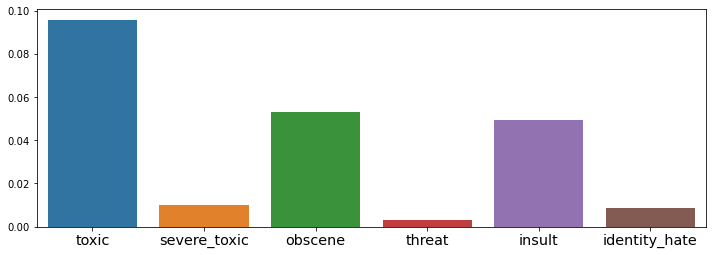

In [9]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

class_sum = [df[col].sum()/len(df) for col in target_columns]

fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.barplot(x=target_columns, y=class_sum, ax=ax)
ax.set_xticklabels(target_columns, fontsize='x-large');

In [11]:
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens
0,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,0,0,0,0,0,0,0,aww matches background colour seemingly stuck ...
2,0,0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0,0,0,0,0,0,0,make real suggestions improvement wondered sec...
4,0,0,0,0,0,0,0,sir hero chance remember page


In [10]:
print(stop_now)

NameError: name 'stop_now' is not defined

In [ ]:
for col in target_columns:
    print (col, df[col].sum()/len(df))

In [ ]:
def imbalance_metric(df, target_columns):
    label_counts = np.array([df[col].sum() for col in target_columns])
    IRpL = np.max(label_counts)/label_counts
    meanIR = np.sum(IRpL)/len(IRpL)
    return meanIR

print('mean imbalance ratio (smaller is better):', imbalance_metric(df, target_columns))

In [ ]:
# Undersample the data to minimize imbalance ratio

sample_per_label = 500 # we can play with this number, larger number means more imbalance

counts = {'toxic':0, 'severe_toxic':0, 'obscene':0, 'threat':0, 'insult':0, 'identity_hate':0}

new_df = pd.DataFrame()

for label in target_columns:
    sample_to_add = np.max([sample_per_label - counts[label], 0])
    
    if sample_to_add <= 0: continue
    
    s = df[df[label] == 1].sample(n=np.min([sample_to_add, df[label].sum()]))
    df.drop(s.index, inplace=True)
    
    new_df = new_df.append(s, ignore_index=True)
    
    # count labels
    for col in target_columns:
        counts[col] += s[col].sum()


In [ ]:
counts

In [ ]:
for col in target_columns:
    print (col, new_df[col].sum())

In [ ]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

class_sum = [new_df[col].sum()/len(df) for col in target_columns]

fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.barplot(x=target_columns, y=class_sum, ax=ax)
ax.set_xticklabels(target_columns, fontsize='x-large');

In [ ]:
print('mean imbalance ratio (smaller is better):', imbalance_metric(new_df, target_columns))

In [ ]:
len(new_df)

In [ ]:
del df
df = new_df
del new_df

In [ ]:
print(stop_now)

# Preprocessing: tokens to vectors

In [ ]:
tokenizer = TweetTokenizer()
df['tokens'] = df['comment_text'].str.lower().apply(tokenizer.tokenize)

In [ ]:
df.head()

In [ ]:
cachedStopWords = stopwords.words("english")
def remove_stopwords(tokens):
    return [token for token in tokens if token not in cachedStopWords]

df['tokens_nostop'] = df['tokens'].apply(remove_stopwords)

In [ ]:
df.head()

In [ ]:
def join_tokens(tokens):
    return ' '.join(tokens)

df['join_tokens'] = df['tokens_nostop'].apply(join_tokens)

In [ ]:
df.drop(['id','comment_text'], axis=1, inplace=True)
df.head()

Stratification

## Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df.join_tokens.to_list()).toarray()

In [ ]:
np.shape(bow_matrix)

Too many basis words. Use PCA to cut them.

In [ ]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline

#pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA())])

#pca_pipe.fit(bow_matrix)

# n-grams

In [ ]:
bigrams = CountVectorizer(ngram_range=(2,2))
bigrams_matrix = bigrams.fit_transform(df.join_tokens.to_list())

In [ ]:
names = bigrams.get_feature_names()

In [ ]:
import random
random.choices(names, k=10)

In [ ]:
np.shape(bigrams_matrix)

# TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df.join_tokens.to_list()).toarray()

In [ ]:
np.shape(tfidf_matrix)

In [ ]:
type(tfidf_matrix)

In [ ]:
df.drop(['join_tokens'], axis=1, inplace=True)

In [ ]:
df.head()

## Splitting into train and test with stratify

now just for tfidf

In [ ]:
X_train, y_train, X_test, y_test = iterative_train_test_split(tfidf_matrix, df[target_columns].to_numpy(), test_size = 0.2)

In [ ]:
a = dict(Counter(combination for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row))

{k: v / total for total in (sum(a.values()),) for k, v in a.items()}

In [ ]:
a = dict(Counter(combination for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row))

{k: v / total for total in (sum(a.values()),) for k, v in a.items()}

## Modeling 0 versus 1 only

In [12]:
def binary(inp):
    if inp == 0: out = 0
    else: out = 1
    return out

df['negative_comments'] = df['label_sum'].apply(binary)

df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
0,0,0,0,0,0,0,0,explanation edits made username hardcore metal...,0
1,0,0,0,0,0,0,0,aww matches background colour seemingly stuck ...,0
2,0,0,0,0,0,0,0,hey man really trying edit war guy constantly ...,0
3,0,0,0,0,0,0,0,make real suggestions improvement wondered sec...,0
4,0,0,0,0,0,0,0,sir hero chance remember page,0


In [13]:
df.negative_comments.unique()

array([0, 1])

## Spliting into training and test set with stratification

In [18]:
test_size_0 = int(0.2 * len(df[df.negative_comments == 0]))
test_size_1 = int(0.2 * len(df[df.negative_comments == 1]))

In [20]:
df_test_0 = df[df.negative_comments == 0].sample(n=test_size_0, random_state=101)
df_test_1 = df[df.negative_comments == 1].sample(n=test_size_1, random_state=101)
df_test   = df_test_0.append(df_test_1)

In [21]:
df_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
26349,0,0,0,0,0,0,0,internet media shreveport tag placed internet ...,0
13063,0,0,0,0,0,0,0,yes disqualifications baseless ever supported ...,0
119707,0,0,0,0,0,0,0,ref go onto tube type tna video game angle v s...,0
41466,0,0,0,0,0,0,0,thanks sorry seen previous versions good faith...,0
113955,0,0,0,0,0,0,0,announced playstation kingdom hearts iii please,0


In [23]:
df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
df_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_sum,join_tokens,negative_comments
1,0,0,0,0,0,0,0,aww matches background colour seemingly stuck ...,0
2,0,0,0,0,0,0,0,hey man really trying edit war guy constantly ...,0
3,0,0,0,0,0,0,0,make real suggestions improvement wondered sec...,0
4,0,0,0,0,0,0,0,sir hero chance remember page,0
6,1,1,1,0,1,0,4,cocksucker piss around work,1


In [24]:
df_train.negative_comments.sum()/len(df_train)

0.10235261335137932

In [25]:
df_test.negative_comments.sum()/len(df_test)

0.10171776064196603

In [26]:
del df
del df_test_0
del df_test_1

## TF-IDF

In [46]:
vectorizer = TfidfVectorizer()

tfidf_train = vectorizer.fit_transform(df_train.join_tokens.to_list()).toarray()

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

logres = LogisticRegressionCV(cv=3, scoring='recall')

logres.fit(tfidf_train, df_train['negative_comments'])

# Modeling

In [ ]:
clf = OneVsRestClassifier(LogisticRegression())

In [ ]:
print('Accuracy per label')
for i in range(len(target_columns)):
    clf.fit(X_train, y_train[:,i])
    pred = clf.predict(X_test)
    print(target_columns[i], accuracy_score(y_test[:,i], pred))

In [ ]:
from sklearn.multioutput import MultiOutputClassifier

In [ ]:
mlc = MultiOutputClassifier(LogisticRegression())
mlc.fit(X_train, y_train)

In [ ]:
pred = mlc.predict(X_test)

In [ ]:
mcm = multilabel_confusion_matrix(y_test, pred)

In [ ]:
for i in range(len(target_columns)):
    print(target_columns[i], 'accuracy:', (mcm[i,0,0]+mcm[i,1,1])/np.sum(mcm[i]),
          'precision:', mcm[i,1,1]/(mcm[i,1,1]+mcm[i,0,1]),
          'recall:', mcm[i,1,1]/(mcm[i,1,1]+mcm[i,1,0]))
    disp = ConfusionMatrixDisplay(mcm[i])
    disp.plot()
    

In [ ]:
# https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics
# Accuracy for multilabel classifier
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

In [ ]:
Accuracy(y_test, pred)

In [ ]:
def exact_match_ratio(y_true, y_pred):
    return np.all(y_pred == y_true, axis=1).mean()

exact_match_ratio(y_test, pred)

In [ ]:
accuracy_score(y_test, pred) # is the exact match ratio

## Neural Network

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy

In [ ]:
def build_network(n_features, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0.):
    ''' Building neural network model '''
    model = Sequential()
    model.add(Dense(n_nodes, activation=activ_func, use_bias=True, input_shape=(n_features,)))
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=activ_func, use_bias=True))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, input_shape=(n_nodes,)))
    model.add(Dense(n_output, activation='sigmoid'))
    return model

In [ ]:
def fit_network(X, y, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0., epochs=10):
    # Building neural network model
    n_features = np.shape(X)[1]
    model = build_network(n_features, n_output, n_layers, n_nodes, activ_func, dropout_rate)
    # Compiling model
    early_stopping_monitor = EarlyStopping(patience=5)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[binary_accuracy])
    # Fitting model
    history = model.fit(X, y,
                        validation_split=0.2, epochs=epochs,
                        shuffle=True, callbacks=[early_stopping_monitor])
    #model.save('neuralnetwork.h5')
    return model, history

In [ ]:
model, history = fit_network(X_train, y_train, n_output=y_train.shape[1], epochs=50)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
Accuracy(y_test, y_pred.round())

In [ ]:
exact_match_ratio(y_test, y_pred.round())

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='validation')
plt.xlabel('epochs', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.legend(loc='lower right', fontsize=15)
plt.show()

## BERT

In [ ]:
import transformers as ppb
import torch

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [ ]:
def make_tokens(inp):
    return tokenizer.encode(inp, max_length=512, truncation=True)

df['bert_tokens'] = df['tokens_nostop'].apply(make_tokens)

df.head()

In [ ]:
tokenized = df['bert_tokens'].to_numpy()

## This goes through and finds the longest tokenized sequence
max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

## This adds the correct number of 0s to the end of the shorter sequences
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
print(np.shape(padded))

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
## We now convert padded and attention_mask
## into tensors
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

## We get embeddings in the same way, but now we add
## the attention_mask argument
with torch.no_grad():
    last_hidden_states = bert_model(input_ids, attention_mask=attention_mask)

In [ ]:
X = last_hidden_states[0].numpy()
#y = df['coding'].to_numpy()

In [ ]:
np.shape(X)

In [ ]:
np.save('last_hidden_states.npy', X)